MSBA 6330 Prof Liu

# Spark Lab 8 - Predict bike sharing Using MLlib's pipeline and Gradient-Boosted Trees (Solution)


**Topics**: *Loading CSV into DataFrame, Droping Columns, Casting column types, split data, plot histogram, plot GroupBy results in a line chart, VectorAssembler, VectorIndexer, GBTRegressor, RegressionEvaluator(RMSE), CrossValidator, ParamGridBuilder, Pipeline, scatter predictions, testing transformers/estimators.* 


This Python notebook demonstrates creating an ML Pipeline to preprocess a dataset, train a Machine Learning model, and make predictions. It is adapted from Databricks's examples.

**Data**: The dataset contains bike rental info from 2011 and 2012 in the Capital bikeshare system, plus additional relevant information such as weather.  This dataset is from Fanaee-T and Gama (2013) and is hosted by the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

**Goal**: We want to learn to predict bike rental counts (per hour) from information such as day of the week, weather, season, etc.  Having good predictions of customer demand allows a business or service to prepare and increase supply as needed.

**Approach**: We will use Spark ML Pipelines, which help users piece together parts of a workflow such as feature processing and model training.  We will also demonstrate [model selection (a.k.a. hyperparameter tuning)](http://spark.apache.org/docs/1.6.0/ml-guide.html) using [Cross Validation](http://spark.apache.org/docs/1.6.0/api/python/pyspark.ml.html) in order to fine-tune and improve our ML model.

## Load and understand the data

1\. Download [our data](http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip) and unzip it. We will load the data file `hour.csv` as a dataframe.  We also cache the data so that we only read it from disk once.

In [4]:
df = sqlContext.read.format('csv').option("inferSchema",True).option("header", 'true').load("file:/home/vmuser/hour.csv")
df.cache()

DataFrame[instant: int, dteday: timestamp, season: int, yr: int, mnth: int, hr: int, holiday: int, weekday: int, workingday: int, weathersit: int, temp: double, atemp: double, hum: double, windspeed: double, casual: int, registered: int, cnt: int]

#### Data description

From the [UCI ML Repository description](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), we know that the columns have the following meanings.

|field|description|
|--|--|
|instant| record index|
|dteday| date|
|season| season (1:spring, 2:summer, 3:fall, 4:winter)|
|yr| year (0:2011, 1:2012)|
|mnth| month (1 to 12)|
|hr| hour (0 to 23)|
|holiday| whether day is holiday or not|
|weekday| day of the week|
|workingday| if day is neither weekend nor holiday is 1, otherwise is 0.|
|weathersit| 1: Clear, Few clouds, Partly cloudy, Partly cloudy; 2:Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist; 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds; 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog|
|temp| Normalized temperature in Celsius. The values are derived via `(t-t_min)/(t_max-t_min)`, `t_min=-8`, `t_max=+39` (only in hourly scale)|
|atemp| Normalized feeling temperature in Celsius. The values are derived via `(t-t_min)/(t_max-t_min)`, `t_min=-16`, `t_max=+50` (only in hourly scale) |
|hum| Normalized humidity. The values are divided to 100 (max)|
|windspeed| Normalized wind speed. The values are divided to 67 (max)|
|casual | count of casual users|
|registered | count of registered users|
|cnt | count of total rental bikes including both casual and registered|



2\. Now display some basic info about the data
- a few rows of the data
- schema
- number of rows

Note, most columns should be numerical ones. If not, you should adjust your data loading statement.

In [5]:
df.limit(5).toPandas()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
df.printSchema()

root
 |-- instant: integer (nullable = true)
 |-- dteday: timestamp (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)



In [8]:
print("Our dataset has {} rows".format(df.count()))

Our dataset has 17379 rows


This dataset is nicely prepared for Machine Learning: values such as weekday are already indexed, and all of the columns except for the date (`dteday`).

## Preprocess data

**label**: We want to predict the count of bike rentals, hence the `cnt` column is our label.

**Features**: We can use the rest as features, except these:
* `casual`, `registered`: The `cnt` column equals the sum of the `casual` + `registered` columns. Unless we are interested in separating `casual` and `registered`, these two are not useful to us. 
* `dteday`:  We will discard it because it is well-represented by the other date-related columns `season`, `yr`, `mnth`, and `weekday`. 
* `instant`: This will not be used for analysis.

3\. Drop `instant`,`dteday`,`casual`,`registered` columns and verify the content and schema

In [9]:
df2 = df.drop("instant").drop("dteday").drop("casual").drop("registered")
df2.limit(5).toPandas()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [10]:
df2.printSchema()

root
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- cnt: integer (nullable = true)



4\.The Spark ML requires float (python) or double (for scala). Let's cast them to double, then verify the schema

In [17]:
df3 = df2.selectExpr("cast(season as DOUBLE)","cast(yr as DOUBLE)","cast(mnth as DOUBLE)", \
                     "cast(hr as DOUBLE)","cast(holiday as DOUBLE)","cast(weekday as DOUBLE)", \
                     "cast(workingday as DOUBLE)","cast(weathersit as DOUBLE)", \
                     "cast(temp as DOUBLE)","cast(atemp as DOUBLE)",
                     "cast(hum as DOUBLE)","cast(windspeed as DOUBLE)","cast(cnt as double)")

In [19]:
df3.printSchema()

root
 |-- season: double (nullable = true)
 |-- yr: double (nullable = true)
 |-- mnth: double (nullable = true)
 |-- hr: double (nullable = true)
 |-- holiday: double (nullable = true)
 |-- weekday: double (nullable = true)
 |-- workingday: double (nullable = true)
 |-- weathersit: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- cnt: double (nullable = true)



5\. Split the dataset randomly to keep 70% for training and 30% for testing. Then verify the count of each dataset

In [20]:
train, test = df3.randomSplit([0.7, 0.3])

In [23]:
print("We have {} training cases and {} test cases.".format(train.count(), test.count()))

We have 12178 training cases and 5201 test cases.


## Step 2. Visualize our data

Now that we have preprocessed our features and prepared a training dataset, we can quickly visualize our data to get a sense of whether the features are meaningful.

### Histogram of variables

To do a histogram of values in DataFrame, you must keep in mind that the data volume is large and you may want to collect the data and run the historgram analysis locally. 

- One approach is to use the histogram API implemented in RDD (DF to RDD conversion is required)
- The other approach (less preferred) is to sample the data and collect it to do an approximate local histogram. 

The following function is designed to plot a histogram based on the RDD returned by core spark's histogram API.

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def create_hist(rdd_histogram_data,field):
    """Given an RDD.histogram and field name, plot a histogram bar chart
       example usage: created_hist(rdd_generated_by_spark_histogram_api,"FileName")
    """
    heights = np.array(rdd_histogram_data[1])
    full_bins = rdd_histogram_data[0]
    mid_point_bins = full_bins[:-1]  #mid point of bins except for the last one
    #bar width is calculated as 80% of bin width
    widths = [(i - j)*0.8 for i, j in zip(full_bins[:-1], full_bins[1:])]
    bar = plt.bar(mid_point_bins, heights, width=widths, color='b')
    plt.ylabel('Frequency')
    plt.title('Histogram of '+field)  
    return bar

6\. Choose the `cnt` column and convert it to `RDD[integer]`, then call RDD's `histogram` API, save the result in `hist_rdd`. Then call the above function to plot the resulting histogram RDD. 

In [36]:
hist_rdd = train.select('cnt').rdd.map(lambda r:r.cnt).histogram(10)

<BarContainer object of 10 artists>

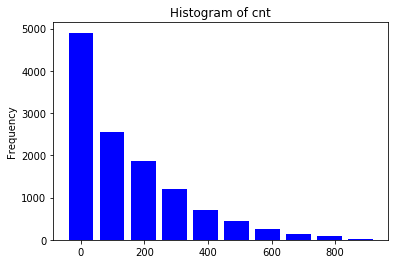

In [35]:
create_hist(hist_rdd, "cnt")


The second approach is to 

- take a small enough sample of the data using `Dataframe.sample()`
- then convert it to a Pandas dataframe using for ploting.

7\. Sample the `cnt` column data by 30%, convert it to a Pandas DataFrame `pd_cnt`, then plot the histogram the `cnt` column in `pd_cnt`

In [24]:
pd_cnt = train.select('cnt').sample(False, 0.30).toPandas()

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

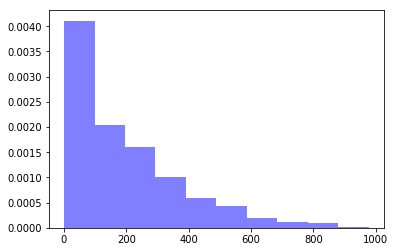

In [47]:
plt.hist(cnt_hist['cnt'], 10, normed=1, facecolor='blue', alpha=0.5)
plt.show()

### Plot Label and a feature in a line chart

In the below plot, we compare bike rental counts versus hour of the day.  As one might expect, rentals are low during the night, and they peak in the morning (8am) and in the early evening (6pm).  This indicates the `hr` feature is useful and can help us predict our label `cnt`.  On your own, you can try visualizing other features to get a sense of how useful they are in this task.


8\. Compute the hourly count of rental events using Spark SQL, saved the resulting dataframe as `df_cntByHr`

In [50]:
# we first import SQL functions, so that we can use them in the agg API
from pyspark.sql import functions as f
# we use agg so that you can specify an alias
df_cntByHour = train.groupBy('hr').agg(f.avg('cnt').alias('avg_cnt'))

In [51]:
df_cntByHour.show()

+----+------------------+
|  hr|           avg_cnt|
+----+------------------+
| 8.0| 361.1417322834646|
| 0.0|              54.8|
| 7.0| 212.7191011235955|
|18.0| 425.6058823529412|
| 1.0| 32.42395437262358|
| 4.0|               6.4|
|23.0| 87.81065088757397|
|11.0|203.21544715447155|
|21.0|175.01004016064257|
|14.0|         235.28125|
|22.0|131.01020408163265|
| 3.0|11.394059405940594|
|19.0| 315.1414728682171|
| 2.0|24.444227005870843|
|17.0| 465.1414728682171|
|10.0| 176.4921568627451|
|13.0| 257.9901768172888|
| 6.0| 74.83101391650099|
|20.0| 230.4591439688716|
| 5.0| 19.91231732776618|
+----+------------------+
only showing top 20 rows



9\. Convert Spark DataFrame `df_cntByHour` to Pandas `pd_cntByHour`, and sort it by values of `hr` (required for plotting)

In [59]:
pd_cntByHour = df_cntByHour.toPandas().sort_values("hr")

In [60]:
pd_cntByHour.head()

,hr,avg_cnt
1,0.0,54.800000
4,1.0,32.423954
13,2.0,24.444227
11,3.0,11.394059
5,4.0,6.400000


10\. Plot the `pd_cntByHour` as a line chart

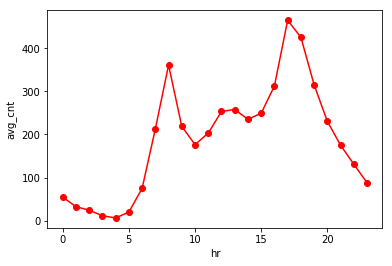

In [61]:
plt.plot(pd_cntByHour["hr"],pd_cntByHour["avg_cnt"],'ro-')
plt.xlabel("hr")
plt.ylabel("avg_cnt")
plt.show()

## Step 3. Train a Machine Learning Pipeline

Now that we have understood our data and prepared it as a DataFrame with numeric values, let's learn an ML model to predict bike sharing rentals in the future.  Most ML algorithms expect to predict a single "label" column (`cnt` for our dataset) using a single "features" column of feature vectors.  

We will put together a simple Pipeline with the following stages:
* [`VectorAssembler`](http://spark.apache.org/docs/1.6.0/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler): Assemble the feature columns into a feature vector.
* [`VectorIndexer`](http://spark.apache.org/docs/1.6.0/api/python/pyspark.ml.html#pyspark.ml.feature.VectorIndexer): Identify columns which should be treated as categorical.  This is done heuristically, identifying any column with a small number of distinct values as being categorical.  For us, this will be the `yr` (2 values), `season` (4 values), `holiday` (2 values), `workingday` (2 values), and `weathersit` (4 values).
* [`GBTRegressor`](http://spark.apache.org/docs/1.6.0/api/python/pyspark.ml.html#pyspark.ml.regression.GBTRegressor): This will use the Gradient-Boosted Trees (GBT) algorithm to learn how to predict rental counts from the feature vectors.
* [`RegressionEvaluator`](http://spark.apache.org/docs/1.6.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator): This specifies the evaluation metric used for the regression model.
* [`CrossValidator`](http://spark.apache.org/docs/1.6.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator): The GBT algorithm has several hyperparameters, and tuning them to our data can improve accuracy.  We will do this tuning using Spark's Cross Validation framework, which automatically tests a grid of hyperparameters and chooses the best.

![Image of Pipeline](http://training.databricks.com/databricks_guide/1-init.png)

First, we define the feature processing stages of the Pipeline:

10\. Create a vector assembler `VectorAssembler` that assembles the feature columns into a feature vector with column name  `rawFeatures`. Name it `va`. Note that all fields in `df3` will be used except for `cnt`


In [62]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer
featuresCols = df3.columns
# exclude the label column
featuresCols.remove('cnt')
# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
va = VectorAssembler(inputCols=featuresCols, outputCol="rawFeatures")

11\. Verify your assembler by transforming `df3` to a new dataframe called `assembled` and show some sample rows from it. 

In [69]:
## verify your vector assembler
assembled = va.transform(df3)
assembled.limit(3).toPandas()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,rawFeatures
0,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,16.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 6.0, 0.0, 1.0, 0.24,..."
1,1.0,0.0,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,40.0,"[1.0, 0.0, 1.0, 1.0, 0.0, 6.0, 0.0, 1.0, 0.22,..."
2,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,32.0,"[1.0, 0.0, 1.0, 2.0, 0.0, 6.0, 0.0, 1.0, 0.22,..."


12\. Create a VectorIndexer that indexes all features in `rawFeatures` with <= 4 distinct values. The output column should be called `features`, and the VectorIndex should be called `vi`

In [66]:
# This identifies categorical features and indexes them, the maxicum category for categorical variables is 4
# columns with more than 4 distinct values will be treated as continous 
vi = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=4)

13\. Verify your VectorIndexer by transforming `assembled` to a new dataframe called `indexed` and show some sample rows from it. 

In [72]:
## verify your vector assembler
indexed = vi.fit(assembled).transform(assembled)
indexed.select("rawFeatures","features").limit(3).collect()

[Row(rawFeatures=DenseVector([1.0, 0.0, 1.0, 0.0, 0.0, 6.0, 0.0, 1.0, 0.24, 0.2879, 0.81, 0.0]), features=DenseVector([0.0, 0.0, 1.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.24, 0.2879, 0.81, 0.0])),
 Row(rawFeatures=DenseVector([1.0, 0.0, 1.0, 1.0, 0.0, 6.0, 0.0, 1.0, 0.22, 0.2727, 0.8, 0.0]), features=DenseVector([0.0, 0.0, 1.0, 1.0, 0.0, 6.0, 0.0, 0.0, 0.22, 0.2727, 0.8, 0.0])),
 Row(rawFeatures=DenseVector([1.0, 0.0, 1.0, 2.0, 0.0, 6.0, 0.0, 1.0, 0.22, 0.2727, 0.8, 0.0]), features=DenseVector([0.0, 0.0, 1.0, 2.0, 0.0, 6.0, 0.0, 0.0, 0.22, 0.2727, 0.8, 0.0]))]

14\. Define the GBTRegressor. `GBTRegressor` takes `features` as feature vectors and `cnt` as labels. Save the resulting GBTRegressor as `gbt`. 

In [74]:
from pyspark.ml.regression import GBTRegressor
# Takes the "features" column and learns to predict "cnt"
gbt = GBTRegressor(labelCol="cnt")

15\. We create an evaluator `e` and specify RMSE as the evaluation metric

In [75]:
from pyspark.ml.evaluation import RegressionEvaluator
# We define an evaluation metric.  This tells CrossValidator how well 
# we are doing by comparing the true labels with predictions.
e = RegressionEvaluator(metricName="rmse", labelCol=gbt.getLabelCol(), predictionCol=gbt.getPredictionCol())

We wrap the model training stage within a `CrossValidator` stage.  `CrossValidator` knows how to call the GBT algorithm with different hyperparameter settings.  It will train multiple models and choose the best one, based on minimizing some metric. In this example, our metric is **Root Mean Squared Error (RMSE)** as defined above.

16\. Create a parameter grid `paramGrid` that explores two values for GTB's maxDepth parameters: 2 and 5

  - `maxDepth`: max depth of each decision tree in the GBT ensemble
  - `maxIter`: iterations, i.e., number of trees in each GBT ensemble

In this example, we keep these values small.  In practice, to get the highest accuracy, you would likely want to try deeper trees (10 or higher) and more trees in the ensemble (>100).

In [77]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# Define a grid of hyperparameters to test:

paramGrid = ParamGridBuilder() \
  .addGrid(gbt.maxDepth, [2, 5])\
  .build() # .addGrid(gbt.maxIter, [10, 100])


17\. Create a CrossValidator `cv`, which uses `gbt` as estimator, `e` as evaluator and `paramGrid` as parameter maps. 


In [78]:
cv = CrossValidator(estimator=gbt, evaluator=e, estimatorParamMaps=paramGrid)

Finally, we can tie our feature processing and model training stages together into a single `Pipeline`.

![Image of Pipeline](http://training.databricks.com/databricks_guide/5-pipeline.png)

18\. Create a Pipeline `pipeline` according to the above diagram.

In [79]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[va, vi, cv])

#### Train the Pipeline!

Now that we have set up our workflow, we can train the Pipeline in a single call.  Calling `fit()` will run feature processing, model tuning, and training in a single call.  We get back a fitted Pipeline with the best model found.

***Note***: This next cell can take up to **10 minutes**.  This is because it is training *a lot* of trees:
* For each random sample of data in Cross Validation,
  * For each setting of the hyperparameters,
    * `CrossValidator` is training a separate GBT ensemble which contains many Decision Trees.

19\. Train the pipeline and save the resulting model as `pipelineModel`

In [80]:
pipelineModel = pipeline.fit(train)

## Step 4. Make predictions, and evaluate results

Our final step will be to use our fitted model to make predictions on new data.  We will use our held-out test set, but you could also use this model to make predictions on completely new data.  For example, if we created some features data based on weather predictions for the next week, we could predict bike rentals expected during the next week!

We will also evaluate our predictions.  Computing evaluation metrics is important for understanding the quality of predictions, as well as for comparing models and tuning parameters.

20\. Calling `transform()` on a the `test` dataset to obtain predictions, saving the resulting Dataframe as `predictions`

In [83]:
predictions = pipelineModel.transform(test)

We expect `predictions` to have a new column `predictions` (as well as intermediate results such as our `rawFeatures` column from previous steps). It is easier to view the results when we limit the columns displayed to:
* `cnt`: the true count of bike rentals
* `prediction`: our predicted count of bike rentals
* feature columns: our original (human-readable) feature columns

21\. Display `cnt`, `prediction`, and original feature columns, limit results to 10 rows

In [84]:
predictions.select("cnt", "prediction", *featuresCols).limit(10).toPandas()

,cnt,prediction,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,39.0,48.541597,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.26,0.3030,0.56,0.0000
1,17.0,125.835599,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.46,0.4545,0.88,0.2985
2,7.0,5.977506,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.06,0.0606,0.41,0.1940
3,7.0,11.859730,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0.24,0.2273,0.65,0.2239
4,7.0,14.341144,1.0,0.0,1.0,0.0,0.0,3.0,1.0,2.0,0.16,0.1970,0.86,0.0896
5,11.0,13.553244,1.0,0.0,1.0,0.0,0.0,4.0,1.0,1.0,0.18,0.2424,0.55,0.0000
6,21.0,13.974401,1.0,0.0,1.0,0.0,0.0,5.0,1.0,2.0,0.24,0.2273,0.70,0.2537
7,28.0,35.405591,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.18,0.2424,0.55,0.0000
8,16.0,47.743981,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000
9,17.0,32.681412,1.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,0.20,0.1970,0.47,0.2239


Are these good results?  They are not perfect, but you can see correlation between the counts and predictions.  And there is room to improve---see the next section for ideas to take you further!

Before we continue, we give two tips on understanding results:

**(1) Metrics**: Manually viewing the predictions gives intuition about accuracy, but it can be useful to have a more concrete metric.  Below, we compute an evaluation metric which tells us how well our model makes predictions on all of our data.  In this case (for [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)), lower is better.  This metric does not mean much on its own, but it can be used to compare different models.  (This is what `CrossValidator` does internally.)

22\. Obtain the RMSE for predictions

In [85]:
rmse = e.evaluate(predictions)
print("RMSE on our test set: {}".format(rmse))

RMSE on our test set: 62.600302328096944


**(2) Visualization**: Plotting predictions vs. features can help us make sure that the model "understands" the input features and is using them properly to make predictions.  Below, we can see that the model predictions are correlated with the hour of the day, just like the true labels were.

23\. Plot a scatter plot on a 20% sampel of (`cnt`,`prediction`) pair.

In [70]:
cnt_prediction = predictions.sample(False,0.2).select('cnt','prediction').toPandas()

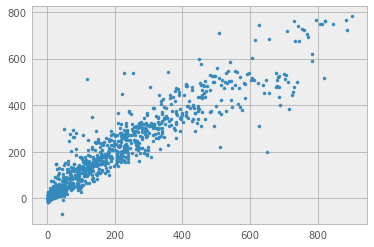

In [71]:
plt.scatter(cnt_prediction['cnt'],cnt_prediction['prediction'],marker='.')

#### Improving our model

There are several ways we could further improve our model:
* **Expert knowledge**: We may not be experts on bike sharing programs, but we know a few things we can use:
  * The count of rentals cannot be negative.  `GBTRegressor` does not know that, but we could threshold the predictions to be `>= 0` post-hoc.
  * The count of rentals is the sum of `registered` and `casual` rentals.  These two counts may have different behavior.  (Frequent cyclists and casual cyclists probably rent bikes for different reasons.)  The best models for this dataset take this into account.  Try training one GBT model for `registered` and one for `casual`, and then add their predictions together to get the full prediction.
* **Better tuning**: To make this notebook run quickly, we only tried a few hyperparameter settings.  To get the most out of our data, we should test more settings.  Start by increasing the number of trees in our GBT model by setting `maxIter=200`; it will take longer to train but can be more accurate.
* **Feature engineering**: We used the basic set of features given to us, but we could potentially improve them.  For example, we may guess that weather is more or less important depending on whether or not it is a workday vs. weekend.  To take advantage of that, we could build a few feature by combining those two base features.  MLlib provides a suite of feature transformers; find out more in the [ML guide](http://spark.apache.org/docs/latest/ml-features.html).

#### Learning more

Check out the other example notebooks in this guide for more ideas about Pipelines, working with datasets, and more. Here are some to start with:
* [Full ML Workflow using Pipelines](https://docs.databricks.com/spark/latest/mllib/index.html)